In [6]:
from Izh_net import *
from net_preparation import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from tqdm import tqdm
import os
import numpy as np
from scipy.signal import correlate
from scipy.fft import fft

def run(net, flexor, extensor, Limb, T, Iapp, f_id=0, e_id=1):
    net.set_init_conditions(v_noise=np.random.normal(size=net.N, scale=3))
    flexor.set_init_conditions()
    extensor.set_init_conditions()
    Limb.set_init_conditions()
    dt = T[1] - T[0]
    N = len(net)
    V = np.zeros((len(T), N))
    F_f = np.zeros(len(T))
    F_e = np.zeros(len(T))
    W = np.zeros(len(T))
    Q = np.zeros(len(T))
    for i, t in enumerate(T):
        V[i] = net.V_prev
        F_f[i] = flexor.F_prev
        F_e[i] = extensor.F_prev
        Q[i] = Limb.q
        W[i] = Limb.w
        net.step(dt=dt, Iapp=Iapp[i])
        uf = net.output[f_id]
        ue = net.output[e_id]
        flexor.step(dt=dt, u=uf)
        extensor.step(dt=dt, u=ue)
        Limb.step(dt=dt, F_flex=flexor.F, F_ext=extensor.F)
    return V, F_f, F_e, Q

def calc_T(bursts):    
    dists = np.diff(bursts[:, 0])
    return np.mean(dists), np.std(dists)

In [43]:
def create_sys(N = 2, names = None):
    # Creating network
    a = 0.002
    b = 0.27
    c = -50
    d = 2
    A = a*np.ones(N)
    B = b*np.ones(N)
    C = c*np.ones(N)
    D = d*np.ones(N)
    net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)
    if names != None:
        net.names = names
    net.M = np.ones((N, N))
    # Limb settings
    flexor = SimpleAdaptedMuscle(N=5)
    extensor = SimpleAdaptedMuscle(N=5)
    Limb = OneDOFLimb(q0=np.pi/2, w0=0, a1=0.2, a2=0.07, m=0.3, ls=0.3, b=0.01,)
    return net, flexor, extensor, Limb


def draw(T, V, F_f, F_e, Q, net):
    N = net.N
    fig = plt.figure(figsize=(7, 4))
    firings = create_firing_rastr(V, T, 30)
    mask1 = np.logical_and(firings[0]>3000, firings[1]==0)
    bursts = get_bursts_regions(find_bursts(firings[0][mask1], T_max))
    period, std = calc_T(bursts)
    plt.subplot(211)
    for i in range(N):
        plt.plot(T, V[:, i], label=f"{net.names[i]}")
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(rf'Average Membrane Potential of Neurons w1 = {w}, tau = {tau}, T={period:.3f}$\pm${std:.3f}')
    plt.legend()
        
    plt.subplot(2, 2, 3)
    plt.plot(T, F_f, label="F_flex", color='k')
    plt.plot(T, F_e, label="F_ext", color='r')
    plt.xlabel('Time (ms)')
    plt.ylabel('Value')
    plt.legend()
    plt.subplot(224)
    plt.plot(T, Q, label="Q", color='k', linestyle='-')     
    plt.legend()
    plt.tight_layout()
    return fig, period

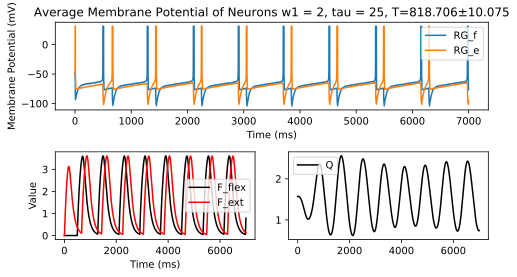

In [44]:
N=2
names = ['RG_f', 'RG_e']
net, flexor, extensor, Limb = create_sys(N=N, names=names)
w = 2
tau = 25
net.set_weights(np.array([
                        [0, -w],
                        [-w, 0],
                    ])
                    )
            
net.set_synaptic_relax_constant(
                        np.array(
                        [
                            [1, tau],
                            [tau, 1],
                        ]
                        )
                    )
# Set the random seed for reproducibility
np.random.seed(2000)
# prepare simulations
T_max = 7000
time_scale = 3
T = np.linspace(0, T_max, T_max*time_scale)
noise_std=2
input = 0.1*np.random.normal(size=(len(T), N), scale=noise_std)

V, F_f, F_e, Q = run(net, flexor, extensor, Limb, T, input)
fig, period = draw(T, V, F_f, F_e, Q, net)
fig.savefig(f'./img/{period:.0f}ms.png')
plt.show()

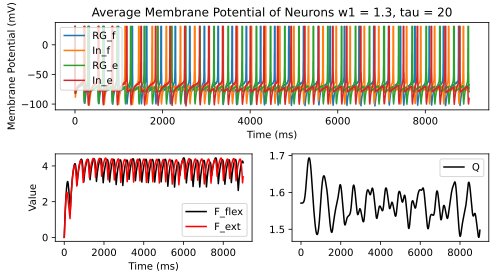

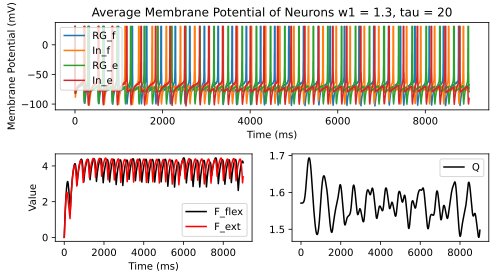

In [4]:
N=4
names=["RG_f","In_f", "RG_e", "In_e"]
net, flexor, extensor, Limb = create_sys(N=N, names=names)
w = 1.3
tau = 20
net.set_weights(np.array([
                        [0, 0, 0, -w],
                        [-w, 0, 0, 0],
                        [0, -w, 0, 0],
                        [0, 0, -w, 0]
                    ])
                    )
            
net.set_synaptic_relax_constant(
                        np.array(
                        [
                        [1, 1, 1, tau],
                        [tau, 1, 1, 1],
                        [1, tau, 1, 1],
                        [1, 1, tau, 1]
                        ]
                        )
                    )
# Set the random seed for reproducibility
np.random.seed(2000)
# prepare simulations
T_max = 9000
time_scale = 3
T = np.linspace(0, T_max, T_max*time_scale)
noise_std=2
input = 0.3*np.random.normal(size=(len(T), N), scale=noise_std)

V, F_f, F_e, Q = run(net, flexor, extensor, Limb, T, input, f_id=0, e_id=2)
draw(T, V, F_f, F_e, Q, net)